In [7]:
import matplotlib.pyplot as plt

In [2]:
def build_matrix(G, ncells, nmutations):
    mat = np.zeros((ncells, nmutations))
    node_map = defaultdict()
    root = None
    for n in G.nodes():
        if G.in_degree(n) == 0:
            node_map[n] = np.array([0,0,0,0,0])
        elif G.out_degree(n) > 0:
            node_map[n] = np.array([0,0,0,0,0])
            for pred in list(nx.ancestors(G, n)):
                if int(pred) <= nmutations:
                    node_map[n][int(pred) - 1] = 1
            node_map[n][int(n) - 1] = 1
        

    for n in G.nodes():
        # Get all outgoing edges from the node
        out_edges = G.out_edges(n)
        # Extract the target nodes from the edges
        outdegree_nodes = [target for _, target in out_edges if G.out_degree(target) == 0]
        for leaf in outdegree_nodes:
            mat[int(leaf[1:])] = node_map[n]
            
    return mat

# Plot Normalized Matrix Error

### Parameters

In [5]:
# Variable Parameters 
ncells_per_sample = 2000
timepoints = [3, 5, 7]
error_rates = [0.01, 0.05, 0.075, 0.10, 0.125, 0.15]
num_replicates = 20

# Fixed Parameters
nmutations = 5

## Imputation Methods Comparison

NameError: name 'cmat' is not defined

<Figure size 432x288 with 0 Axes>

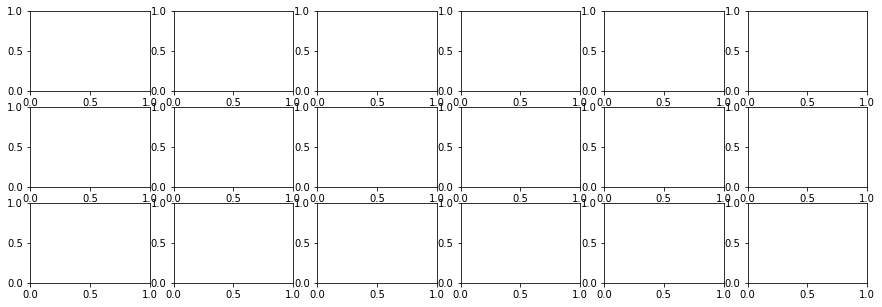

In [8]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(15, 5))
idx = 0
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        PP_diffs = []
        LPR_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = cmat[idx]
                ML_LPR_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/adversarial_cases/ML-LPR_{t}_{prop}_{sd}_B.csv')
                ML_PP_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/adversarial_cases/ML-PP_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'/n/fs/ragr-data/users/aj7381/adversarial_cases/result_{t}_{prop}_{sd}_sphyr.txt', sep=' ',skiprows=2, header=None)


                gv = pgv.AGraph(f'/n/fs/ragr-data/users/aj7381/adversarial_cases/result_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                ML_LPR_character_matrix = ML_LPR_df.values[:, 1:]
                ML_PP_character_matrix = ML_PP_df.values[:, 1:]
                PP_diffs.append(np.sum(np.abs(og_character_matrix - ML_PP_character_matrix))/(ncells_per_sample * nmutations * t))
                LPR_diffs.append(np.sum(np.abs(og_character_matrix - ML_LPR_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))

            idx += 1

        data = pd.DataFrame({'Type': num_replicates*['ConDoR'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':PP_diffs + LPR_diffs + SPhyR_diffs + SCITE_diffs})
        axs[i,j].set_ylim(0, 0.20)
        sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
plt.show()